<a href="https://colab.research.google.com/github/stuabs19/yahoo-baseball/blob/master/DR_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal Customer Selection in Demand Response Programs


## Business Understanding

This use case is inspired by the academic paper, _Classification of new electricity customers based on surveys and smart metering data_ (Viegas, Joaquim L., et.al., Energy 107 (2016) 804-817, ElSevier). 

Demand Response (DR) programs are used to improve generation capacity as load demand increases and the two-way communication (between utilities and users) are enabled through AMI. Instead of installing new power plants in smart grids, utilities encourage users to shift their electricity consumption from peak hours to off-peak hours. 

The number of successfully recruited customers participating in demand response programs is usually low, and resources are wasted on recruitment efforts. However, if utilities can identify customers that are good targets for DR program participation based on their consumption patterns and lifestyles, they may be able to improve the recruitment process for those programs.

## Data Understanding

**Data from the Commission for Energy Regulation**

This data was made available by the _Commission for Energy Regulation_ (CER) via the _Irish Social Science Data Archive_ (ISSDA).

The Commission for Energy Regulation (CER) is the regulator for the electricity and natural gas sectors in Ireland. The CER was first set up in 1999 and works within the framework of national and EU energy policy which aim to create a single European electricity market that best meets the needs of Europe’s energy consumers.

**CER Smart Metering Project**

The CER initiated the Smart Metering Project in 2007 with the purpose of undertaking trials to assess the performance of Smart Meters, their impact on consumers’ energy consumption and the economic case for a wider national rollout. It is a collaborative energy industry-wide project managed by the CER and actively involving energy industry participants including the Sustainable Energy Authority of Ireland (SEAI), the Department of Communications, Energy and Natural Resources (DCENR), ESB Networks, Bord Gáis Networks, Electric Ireland, Bord Gáis Energy and other energy suppliers.

This notebook utilizes customer usage data and residential pre-trial survey data.

Source: https://www.ucd.ie/issda/data/commissionforenergyregulationcer/

Manifest: https://www.ucd.ie/issda/t4media/cer-manifest.pdf

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

height = 12
width = height * 1.6
sns.set(rc={'figure.figsize':(width, height)}, style='whitegrid', font_scale=1)

In [ ]:
usage = pd.read_csv('https://raw.githubusercontent.com/blcrow/ua201/main/cer-usage.csv').set_index('meter_id')
usage.shape

(6019, 49)

In [ ]:
usage.head()

,1,2,3,4,5,6,7,8,9,10,...,40,41,42,43,44,45,46,47,48,DR
meter_id,,,,,,,,,,,,,,,,,,,,,
1000,0.009831,0.006633,0.005496,0.005777,0.005269,0.005213,0.005184,0.005197,0.005314,0.004935,...,0.044685,0.042579,0.042502,0.035672,0.034085,0.032759,0.027904,0.021806,0.016329,0
1001,0.021131,0.021425,0.020928,0.020571,0.020847,0.020516,0.020150,0.020460,0.021116,0.020240,...,0.020512,0.021481,0.020988,0.020957,0.021425,0.021323,0.021248,0.020669,0.019947,1
1002,0.018452,0.012740,0.009479,0.008216,0.007359,0.007105,0.006999,0.007051,0.006743,0.007094,...,0.028863,0.031313,0.032993,0.035704,0.035570,0.035960,0.035620,0.034086,0.027589,0
1003,0.018708,0.017658,0.016445,0.014757,0.014121,0.013317,0.012589,0.012026,0.012650,0.015951,...,0.031650,0.029268,0.028475,0.028219,0.027320,0.026957,0.024453,0.022351,0.020283,1
1004,0.020893,0.018324,0.015967,0.014058,0.012766,0.011614,0.010476,0.009385,0.008719,0.008051,...,0.045097,0.040437,0.040053,0.038586,0.038595,0.035606,0.032349,0.026688,0.023691,0


In [ ]:
usage.dropna(inplace=True)

## Household Survey

**Respondent**
- `Sex`: Sex of respondent: {male, female}
- `Age`: Age of respondent in years: {18-25, 26-35, 36-45, 46-55, 56-65, 65 or more, refused}
- `Employment`: employment status of respondent: {Employee, self-employed, unemployed}
- `Social_class`: Social class of respondent: {AB, C1, C2, DE, F, refused}
- `Education`: Education level of respondent: {none, primary, secondary to intermediate cert junior cert level, secondary to leaving cert level, third level, refused}
- `Income`: Income of respondent before tax in euro: {0-15k, 15k-30k, 30k-50k, 50k-75k, 75k or more, refused}

In [ ]:
survey = pd.read_csv('https://raw.githubusercontent.com/blcrow/ua201/main/CER_survey.csv', na_values=' ')
survey.head()

,ID,Sex,Age,Employment,Social_class,Education,Income,Internet,Home_type,Home_age,...,Desktop,Laptop,Game_console,Washing_machine,Tumble_dryer,Dishwasher,CFL_lightbulbs,Doubleglazed_windows,Attic_insulated,External_walls_insulated
0,1002,1,6,6,4,2,1,2,2,NaN,...,1,1,1,1.0,NaN,NaN,3,5,1,2
1,1003,1,2,1,2,5,3,1,5,NaN,...,1,3,2,2.0,1.0,1.0,3,5,1,1
2,1004,1,4,1,2,5,6,1,3,NaN,...,2,2,2,2.0,1.0,3.0,2,5,1,1
3,1005,2,3,1,2,5,6,1,2,NaN,...,1,2,2,2.0,1.0,NaN,2,5,1,2
4,1008,2,3,1,2,5,6,1,3,NaN,...,4,1,2,1.0,1.0,2.0,5,5,1,2


In [ ]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232 entries, 0 to 4231
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        4232 non-null   int64  
 1   Sex                       4232 non-null   int64  
 2   Age                       4232 non-null   int64  
 3   Employment                4232 non-null   int64  
 4   Social_class              4232 non-null   int64  
 5   Education                 4232 non-null   int64  
 6   Income                    4232 non-null   int64  
 7   Internet                  4232 non-null   int64  
 8   Home_type                 4232 non-null   int64  
 9   Home_age                  422 non-null    float64
 10  Bedrooms                  4232 non-null   int64  
 11  Heat_electricity_central  4232 non-null   int64  
 12  Heat_gas                  4232 non-null   int64  
 13  Heat_oil                  4232 non-null   int64  
 14  Heat_sol

## Join DataFrames

In [ ]:
survey.set_index('ID', inplace=True)

In [ ]:
df = pd.merge(left=usage, right=survey, how='inner', left_index=True, right_index=True)

In [ ]:
df.shape

(4221, 91)

In [ ]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,Desktop,Laptop,Game_console,Washing_machine,Tumble_dryer,Dishwasher,CFL_lightbulbs,Doubleglazed_windows,Attic_insulated,External_walls_insulated
1002,0.018452,0.012740,0.009479,0.008216,0.007359,0.007105,0.006999,0.007051,0.006743,0.007094,...,1,1,1,1.0,NaN,NaN,3,5,1,2
1003,0.018708,0.017658,0.016445,0.014757,0.014121,0.013317,0.012589,0.012026,0.012650,0.015951,...,1,3,2,2.0,1.0,1.0,3,5,1,1
1004,0.020893,0.018324,0.015967,0.014058,0.012766,0.011614,0.010476,0.009385,0.008719,0.008051,...,2,2,2,2.0,1.0,3.0,2,5,1,1
1005,0.011681,0.009916,0.009239,0.008486,0.008058,0.007957,0.007487,0.007645,0.007321,0.007466,...,1,2,2,2.0,1.0,NaN,2,5,1,2
1008,0.021517,0.025340,0.020170,0.019409,0.018390,0.018278,0.017944,0.016977,0.015802,0.015399,...,4,1,2,1.0,1.0,2.0,5,5,1,2


## Split datasets

In [ ]:
# Split the data
X = df.drop('DR', axis=1)
y = df['DR'].copy()

In [ ]:
from sklearn.model_selection import train_test_split

train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

# train is 60% of the original data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_ratio, random_state=48)

# test is  20% of the original data set
# validation is  20% of the original data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

## Missing Values

In [ ]:
percent_missing = X_train.isna().sum() * 100 / len(df)
percent_missing[percent_missing > 0]

Home_age           54.228856
Washing_machine     1.184553
Tumble_dryer       18.834399
Dishwasher         20.113717
dtype: float64

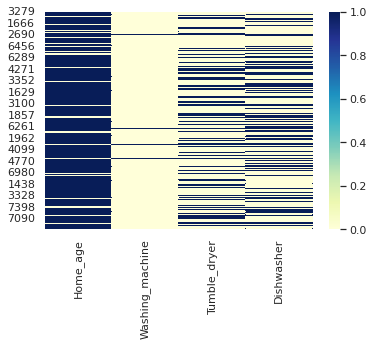

In [ ]:
sns.heatmap(X_train[['Home_age', 'Washing_machine', 'Tumble_dryer', 'Dishwasher']].isna(), cmap='YlGnBu')
plt.show()

**Treatment**
- `Home_age`: greater than 70% missing; drop this feature.
- `Washing_machine`: less than 2% missing; impute.
- `Tumble_dryer`: about 25% missing; impute.
- `Dishwasher`: about 26% missing; impute.

In [ ]:
df.drop('Home_age', axis=1, inplace=True)

### Transformation Pipelines
Your data may require many transformation steps which need to be executed in a particular order. `Pipeline`s are he most common tool used to chain estimators which helps ensure transformations occur in the correct order. 

Characteristics include: 

* Helps with sequences of data transformations. This is useful because there may be many different transformations on the data that must be executed in the same order each time. 
* Also remembers certains values from the training data, like imputation values and standardization values, that will be used to transform the test data.

Note: all estimators in a pipeline, except the last one, must be transformers (i.e., must have a `transform` method). The last estimator may be any type (transformer, classifier, etc.).

In [ ]:
# Create a pipeline object that imputes missing values (with median) and scales using standard scaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # import the class

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
])

In [ ]:
# Call fit_transform with the training data
X_train = pipe.fit_transform(X_train)

In [ ]:
# Use the transform method only on the validation and test data
X_val = pipe.transform(X_val)
X_test = pipe.transform(X_test)

### Get a baseline

In [ ]:
y_train.mean()
# 29% of customers in the training set are DR candidates

0.29541864139020535

#### Train models: Logistic Regression, Decision Tree, and Random Forest

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix # import

In [ ]:
%%time
# Import statement
from sklearn.linear_model import LogisticRegressionCV

lrClf = LogisticRegressionCV(cv=5, max_iter=5000, solver='saga', n_jobs=-1, random_state=48).fit(X_train, y_train)

In [ ]:
# train a decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# define the hyperparameters
params = {'max_depth': [2, 3, 5, 10, 20, 40, 80],
          'min_samples_leaf': [5, 10, 20, 50, 100],
          'criterion': ["gini", "entropy"]
}

gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=48), 
                     param_grid=params, 
                     cv=5, n_jobs=-1, verbose=1, scoring="accuracy")

gridSearch.fit(X_train, y_train)

In [ ]:
dtClf = gridSearch.best_estimator_
print(dtClf)

In [ ]:
gridSearch.scoring

In [ ]:
from sklearn import tree
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(dtClf,
#                    feature_names=X.columns,
#                    class_names=["Non-candidate", "Candidate"],
#                    filled=True)
# plt.savefig('tree.png')

# from google.colab import files
# files.download('tree.png') 

In [ ]:
print(tree.export_text(dtClf))

In [ ]:
%%time
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# define the hyperparameters
params = {'n_estimators': [10, 25, 50, 100, 200, 300, 400, 500],
          'max_features': ['sqrt', 'log2'],
          'max_depth': [2, 3, 5, 10, 20, 40, 80],
          'criterion': ["gini", "entropy"]
}

gridSearch = RandomizedSearchCV(RandomForestClassifier(random_state=48), 
                                n_iter=50,
                                param_distributions=params, 
                                cv=5, n_jobs=-1, verbose=1, scoring="recall")

gridSearch.fit(X_train, y_train)

In [ ]:
rfClf = gridSearch.best_estimator_
print(rfClf)

In [ ]:
print(rfClf.feature_importances_)

### Model Performance

In [ ]:
def evaluate_model(classifier, X_train, y_train, X_val, y_val):
    print("Train Accuracy :", accuracy_score(y_train, classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, classifier.predict(X_train)))
    print("-"*50)
    print("Validation Accuracy :", accuracy_score(y_val, classifier.predict(X_val)))
    print("Validation Precision :", precision_score(y_val, classifier.predict(X_val)))
    print("Validation Recall :", recall_score(y_val, classifier.predict(X_val)))
    print("Validation F1 :", f1_score(y_val, classifier.predict(X_val)))
    print("Validation Confusion Matrix:")
    print(confusion_matrix(y_val, classifier.predict(X_val)))

In [ ]:
# Logistic Regression
evaluate_model(lrClf, X_train, y_train, X_val, y_val)

Train Accuracy : 0.7421011058451816
Train Confusion Matrix:
[[1666  118]
 [ 535  213]]
--------------------------------------------------
Validation Accuracy : 0.7286729857819905
Validation Precision : 0.5517241379310345
Validation Recall : 0.26556016597510373
Validation F1 : 0.35854341736694684
Validation Confusion Matrix:
[[551  52]
 [177  64]]


In [ ]:
# Decision Tree
evaluate_model(dtClf, X_train, y_train, X_val, y_val)

Train Accuracy : 0.957740916271722
Train Confusion Matrix:
[[1746   38]
 [  69  679]]
--------------------------------------------------
Validation Accuracy : 0.7985781990521327
Validation Precision : 0.6651162790697674
Validation Recall : 0.5933609958506224
Validation F1 : 0.6271929824561404
Validation Confusion Matrix:
[[531  72]
 [ 98 143]]


In [ ]:
evaluate_model(rfClf, X_train, y_train, X_val, y_val)

Train Accuracy : 1.0
Train Confusion Matrix:
[[1784    0]
 [   0  748]]
--------------------------------------------------
Validation Accuracy : 0.8803317535545023
Validation Precision : 0.8977272727272727
Validation Recall : 0.6556016597510373
Validation F1 : 0.7577937649880095
Validation Confusion Matrix:
[[585  18]
 [ 83 158]]


#### Evaluate the best model against the test data.

In [ ]:
print("Test Accuracy :", accuracy_score(y_test, rfClf.predict(X_test)))
print("Test Precision :", precision_score(y_test, rfClf.predict(X_test)))
print("Test Recall :", recall_score(y_test, rfClf.predict(X_test)))
print("Test F1 :", f1_score(y_test, rfClf.predict(X_test)))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, rfClf.predict(X_test)))

Test Accuracy : 0.8970414201183432
Test Precision : 0.8952380952380953
Test Recall : 0.7430830039525692
Test F1 : 0.8120950323974082
Test Confusion Matrix:
[[570  22]
 [ 65 188]]


### Plotting feature importance

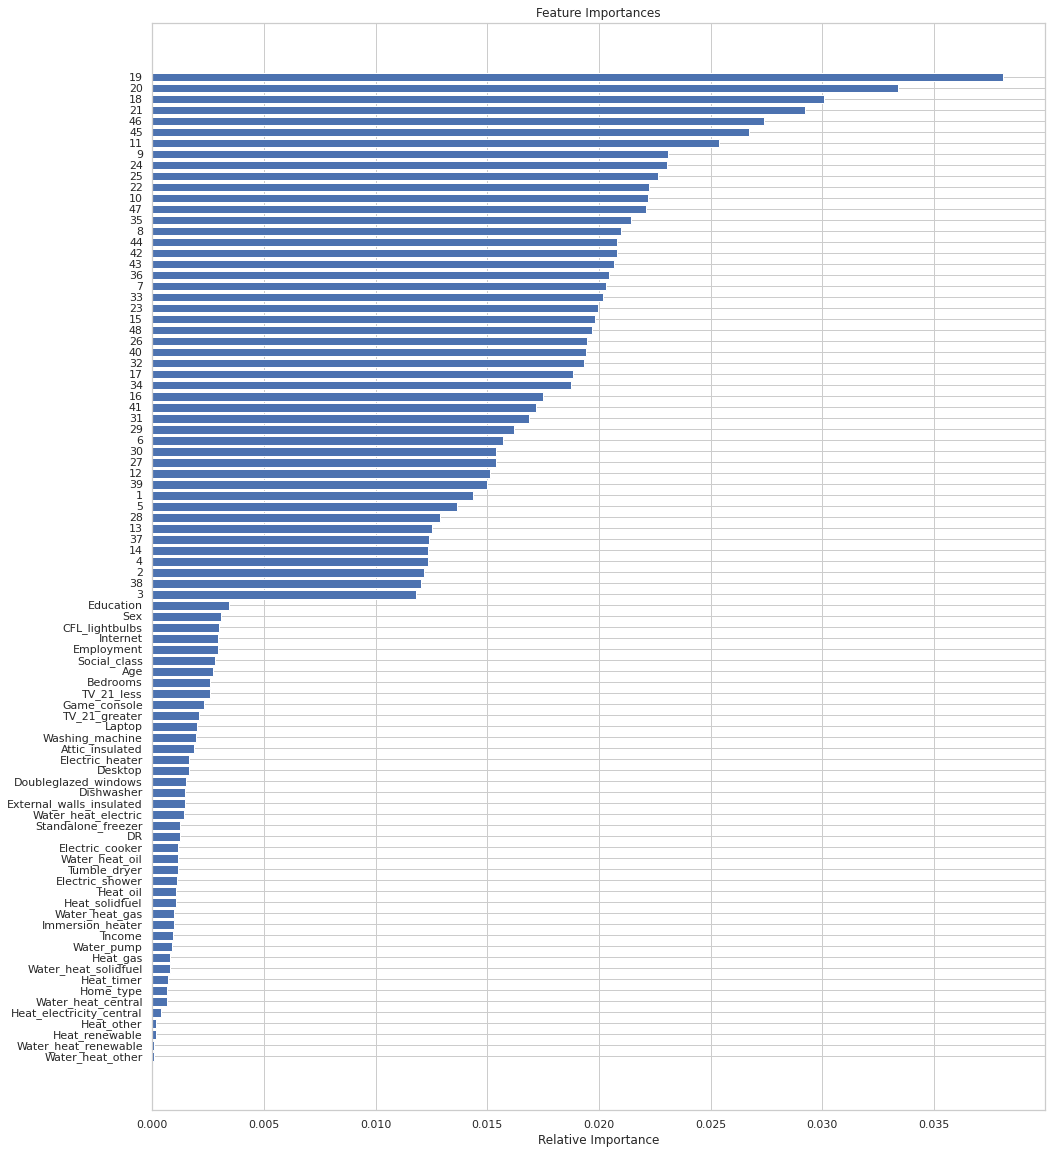

In [ ]:
features = df.columns
importances = rfClf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(16, 20))

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()